# Trace Demo

This notebook uses the trace package to run through multiple example calculations. The following are included:

1. A toy example
2. Calculating RMS of plano-convex lens
3. Optimizing a lens
4. Modeling a telescope

The idea is to demonstrate increasingly advanced usage of trace.

**NOTICE:**<br>
Each section in the notebook can be run independently, but *must be run in order*!

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import trace as tr

In [2]:
# Can be fun for interactive 3D graphics
# %matplotlib notebook

## Basic Usage (Toy Example)

The following demonstrates the basic principles of trace.

In [3]:
# Make a scene and include a lense
scene = tr.Scene()

# Convex at origin, pointing upwards
lens = tr.SphereLens(.1, 0.8, 1, pos=tr.pos(0, 0, 0), axis=tr.vec(0, 0, 1), n=2.0)
lamp = tr.DenseSource(pos=tr.pos(0, 0, 2), k=tr.vec(0, 0, -1), radius=0.8)

In [4]:
# Add the elements to the simulation and run (notice that many elements can be added at once)
scene.add(lens, lamp)
scene.trace()

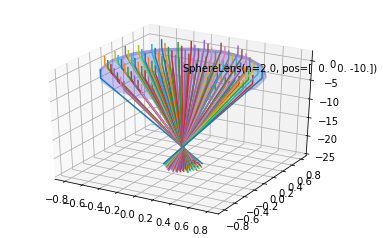

In [5]:
# Show result
tr.graphics.render_3d(scene, extend=25)
plt.show()

## Modelling a plano-convex singlet lens

This examples demonstrates how the trace package can be used to complete task 15 in the laboratory manual.

Calcualting the RMS for the curved surface facing the beam is done in great detail with plots of all intermediate steps. The other way around is done in a single cell, showing only a plot of the final scene and result.

In [6]:
# Start by preparing a scene
scene = tr.Scene()

# Pano-convex lens (all lengths in mm)
# This lens faces the source with the curved surface
lens_front = tr.SphereLens(0.02, 6, 5, pos=tr.pos(0,0,0), axis=tr.vec(1,0,0), n=1.5168)
lens_back = tr.PlaneLens(pos=tr.pos(-1,-6,-6), normal=tr.vec(1,0,0), width=tr.vec(0,12,0), height=tr.vec(0,0,12), n=1)

lamp = tr.DenseSource(pos=tr.pos(25,0,0), k=tr.vec(-1,0,0), radius=5, density=1)

scene.add(lens_front, lens_back, lamp)

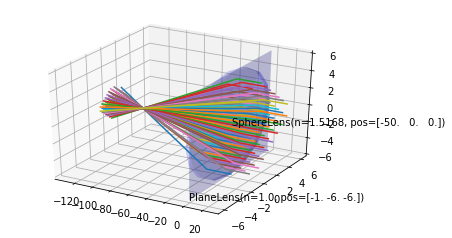

In [7]:
# Render the current scene, to validate the
# placement of objects is correct
scene.trace()
tr.graphics.render_3d(scene, extend=130)
plt.show()

In [8]:
# Find focal point using single ray
scene = scene.reset()
focus_ray = tr.Ray(tr.pos(8,0.1,0.1), k=tr.vec(-1,0,0))
scene.add(focus_ray)
scene.trace_ray(focus_ray)

pt_ray, pt_axi = focus_ray.intersect_axis(tr.pos(0,0,0), tr.vec(1,0,0))
print("Focal Point: {}".format(pt_axi))

Focal Point: [-97.08971706   0.           0.        ]


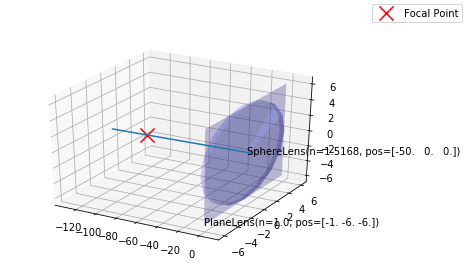

In [9]:
# Display the focal point
fig = tr.graphics.render_3d(scene, extend=130)
fig.axes[0].scatter(*pt_axi, color="red", marker="x", s=200, label="Focal Point")
fig.legend()
plt.show()

RMS: 0.007609925995173922mm


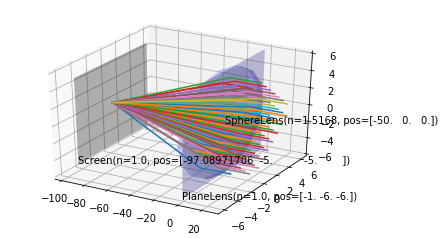

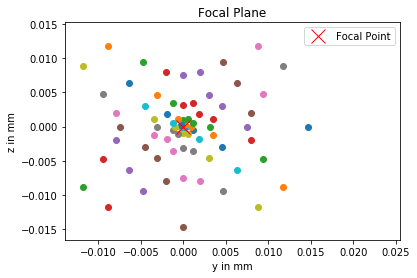

In [10]:
# Now that we know the focal point, place a screen there and record the rms
scene = scene.reset() # Note: This automagically removes the focus ray
screen = tr.Screen(pos=pt_axi-tr.vec(0,5,5), normal=tr.vec(1,0,0), width=tr.vec(0,10,0), height=tr.vec(0,0,10))

scene.add(screen)
scene.trace()

# Calculate RMS from focal point
print("RMS: {}mm".format(screen.RMS(pt_axi)))

# Make nice output graphics
tr.graphics.render_3d(scene)
ax = tr.graphics.render_2d(screen).axes[0]

ax.set_title("Focal Plane")
ax.plot(pt_axi[1], pt_axi[2], "xr", label="Focal Point", markersize=14)
ax.set_xlabel("y in mm")
ax.set_ylabel("z in mm")
ax.legend()

plt.show()

Focal Point: [-101.74833565    0.            0.        ]
RMS: 0.030094346151877786mm


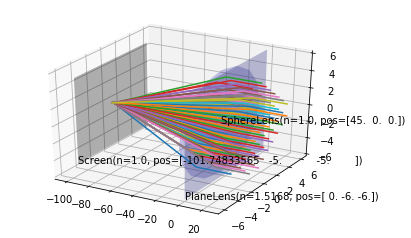

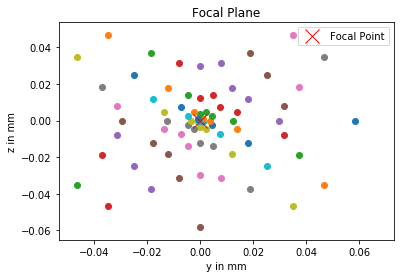

In [11]:
# Without running through all the visuals, do the same trace from the other side
scene = tr.Scene()

# Pano-convex lens (all lengths in mm)
# This lens faces the source with the flat surface
lens_front = tr.SphereLens(-0.02, 6, 0, pos=tr.pos(-5,0,0), axis=tr.vec(1,0,0), n=1)
lens_back = tr.PlaneLens(pos=tr.pos(0,-6,-6), normal=tr.vec(1,0,0), width=tr.vec(0,12,0), height=tr.vec(0,0,12), n=1.5168)

scene.add(lens_front, lens_back, lamp) # Note: Reuse lamp from above

# Find focal point
focus_ray = tr.Ray(tr.pos(8,0.1,0.1), k=tr.vec(-1,0,0))
scene.add(focus_ray)
scene.trace_ray(focus_ray)
_, pt_axi = focus_ray.intersect_axis(tr.pos(0,0,0), tr.vec(1,0,0))
print("Focal Point: {}".format(pt_axi))

# Insert screen at focal point
scene = scene.reset()
screen = tr.Screen(pos=pt_axi-tr.vec(0,5,5), normal=tr.vec(1,0,0), width=tr.vec(0,10,0), height=tr.vec(0,0,10))
scene.add(screen)
scene.trace()

# Calculate RMS from focal point
print("RMS: {}mm".format(screen.RMS(pt_axi)))

# Make nice output graphics
tr.graphics.render_3d(scene)
ax = tr.graphics.render_2d(screen).axes[0]

ax.set_title("Focal Plane")
ax.plot(pt_axi[1], pt_axi[2], "xr", label="Focal Point", markersize=14)
ax.set_xlabel("y in mm")
ax.set_ylabel("z in mm")
ax.legend()

plt.show()

### Result

This example should demonstrate the ease of use provided by trace, as well as how this lens has a much worse performace the 'wrong' way around.

Numerical results for RMS of the plano-convex lens:
1. Curved surface facing beam: ${RMS}_\text{c} = 0.00761\text{mm}$
2. Flat surface facing beam: ${RMS}_\text{f} = 0.03009\text{mm}$

The RMS when facing the beam with the flat surface is more than $30\times$ greater!

## Lens optimization

This optimizes the design of a lens using trace. This is the last task in the laboratory manual.

I personally prefer [lmfit](https://lmfit.github.io/lmfit-py/index.html) to using `scipy` directly, as it has a much cleaner interface. However it is sadly not pre-installed on the lab computers and can thus not be used here.

#### Volatile types

Geometry is immutable. This has several advantages, such as making interactive sessions like the one above
more safe and allowing very efficient implementations of things like `Scene.reset()`, which creates a new
scene, but is able to share all geometry objects.

Hovever, creating an new object every time we want to update the curvature of a lens is rather costly. To that end, `trace` introduces volatile types. These are less safe and are not supported in operations like `Scene.reset()`, but
allow for efficient in-place variation of geometry attributes.

To create a volatile type, any variable parameters must be passed as `Variable(initial_value)`. Before this object can
be used, it must be marked as volatile by calling `obj = make_volatile(obj)`.

(This functionality is implemented in `trace.optim`)

In [12]:
# We will need a numeric function optimizer for this, like the ones provided by scipy
import scipy.optimize as sp_optim

In [13]:
# Next, we need to defined a function that calculates the RMS based on the lens curvatures
# Our lens is 5 mm deep and has initial curvatures of 0.02

fit_scene = tr.VolatileScene(n=1)

curvature_f = tr.Variable(0.02)
curvature_b = tr.Variable(-0.02)

fit_lens_f = tr.make_volatile(tr.SphereLens(curvature_f, 6, 5, pos=tr.pos(0,0,0), axis=tr.vec(1,0,0), n=1.5168))
fit_lens_b = tr.make_volatile(tr.SphereLens(curvature_b, 6, 0, pos=tr.pos(-5,0,0), axis=tr.vec(1,0,0), n=1))

fit_lamp = tr.DenseSource(radius=5, pos=tr.pos(4,0,0), k=tr.vec(-1,0,0), density=0.8)
fit_screen = tr.Screen(pos=tr.pos(-50,0,0)-tr.vec(0,5,5), normal=tr.vec(1,0,0), width=tr.vec(0,10,0), height=tr.vec(0,0,10))

fit_scene.add(fit_lens_f, fit_lens_b, fit_lamp, fit_screen)

def fn_to_min(x):
    # Step 0: Reset the scene and apply variables
    # (this is different from resetting before, since we use a VolatileScene)
    fit_scene.reset()
    curvature_f.set(x[0])
    curvature_b.set(x[1])
    # Step 1: Trace rays and report RMS
    fit_scene.trace()
    return fit_screen.RMS(tr.pos(-50,0,0))

Initial RMS: 0.14373711379271736


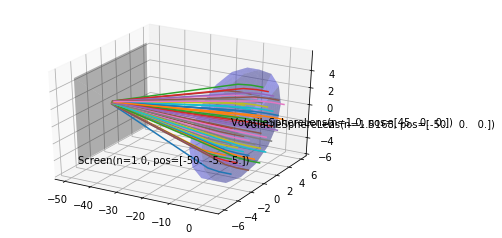

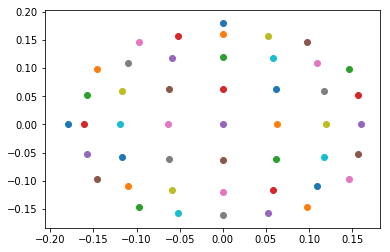

In [14]:
# Let's see if our setup is working ...
print("Initial RMS: {}".format(fn_to_min([0.02, -0.02])))
tr.graphics.render_3d(fit_scene)
tr.graphics.render_2d(fit_screen)
plt.show()

In [15]:
# Now we use scipy to minimize fn_to_min
result = sp_optim.minimize(fn_to_min, [0.02, -0.02], bounds=[(1e-10, 0.1), (-0.1, -1e-10)])
print(result)

      fun: 0.008512098541628332
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.19619200e-05, -3.65618993e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 147
      nit: 21
   status: 0
  success: True
        x: array([ 0.03499081, -0.00548053])


Optimized RMS: 0.008512098541628332


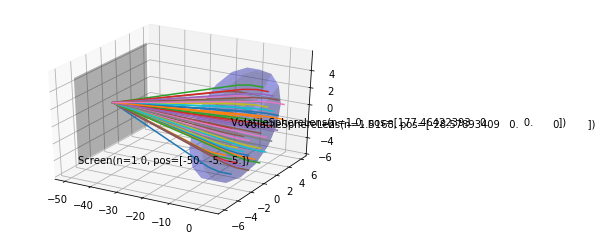

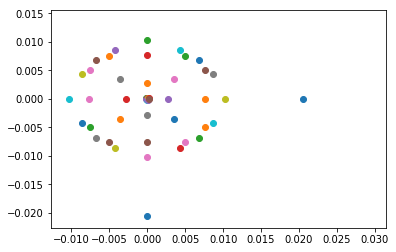

In [16]:
# Finally, we can render the resulting image
print("Optimized RMS: {}".format(fn_to_min(result.x)))
tr.graphics.render_3d(fit_scene)
tr.graphics.render_2d(fit_screen)
plt.show()

## Modelling a telescope

This example uses trace to model a simple telescope.

In [91]:
# As per usual, we start with a scene
scene = tr.VolatileScene()

# We will choose a refractive index and curvature to get a nice even picture
# (just to demonstrate, that we can vary any parameter that is a scalar)
ref_index = tr.Variable(15)
curvature = tr.Variable(-0.035)

# Place mirrors and lenses to assemble our telescope
big_mirror = tr.make_volatile(tr.SphereMirror(curvature, 6, 1, pos=tr.pos(0,0,0), axis=tr.vec(0,-1,0)))
small_mirror = tr.PlaneMirror(pos=tr.pos(-1,-10,-1), width=tr.vec(2,0,0), height=tr.vec(0,-2,2), normal=tr.vec(0,1,1))
eyepiece = tr.make_volatile(tr.SphereLens(0.02, 2, 1, pos=tr.pos(0,-10.8,6), axis=tr.vec(0,0,-1), n=ref_index))
screen = tr.Screen(pos=tr.pos(-2,-12.8,8), width=tr.vec(4,0,0), height=tr.vec(0,4,0), normal=tr.vec(0,0,-1))

the_universe_or_something = tr.DenseSource(pos=tr.pos(0,-20,0), k=tr.vec(0,1,0), radius=5.5, density=1)

scene.add(big_mirror, small_mirror, eyepiece, screen)
scene.add(the_universe_or_something)

In [92]:
# We will get parallel beams on the screen, by minimizing
# the sum of the differences in k-vectors
def min_max_difference(x):
    # Step 0: Reset the scene and apply variables
    # (this is different from resetting before, since we use a VolatileScene)
    scene.reset()
    ref_index.set(x[0])
    curvature.set(x[1])
    # Step 1: Trace rays
    scene.trace()
    # Step 2: Sum differences in k-vectors
    k_0 = screen.hits[0].k
    return 100 * sum([tr.vabs(k_0 - ray.k) for ray in screen.hits[1:]])

In [93]:
import scipy.optimize as sp_optim # in case, this example is run on its own

In [102]:
result = sp_optim.minimize(min_max_difference, [15, -0.035], method="SLSQP", bounds=[(5, 100), (-0.04, -0.02)])
print(result)

     fun: 3.5030836252476125
     jac: array([-4.89658684e-01,  3.97661963e+07])
 message: 'Optimization terminated successfully.'
    nfev: 197
     nit: 25
    njev: 25
  status: 0
 success: True
       x: array([17.25086421, -0.03505494])


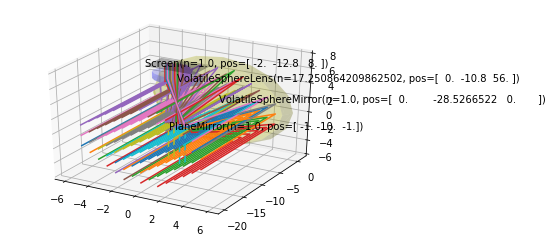

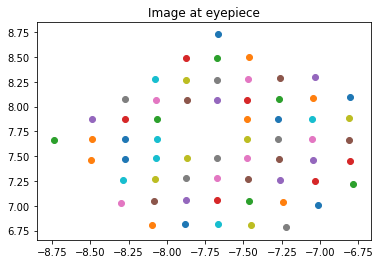

In [103]:
# Render the result
scene.reset()
scene.trace()

tr.graphics.render_3d(scene, extend=5)
ax = tr.graphics.render_2d(screen).axes[0]
ax.set_title("Image at eyepiece")
plt.show()